# Fetching Dataset

## Downloading

In [29]:
import pandas as pd

db_url = "https://archive.ics.uci.edu/static/public/468/online+shoppers+purchasing+intention+dataset.zip"
db_raw = pd.read_csv(db_url, compression='zip', sep=',', header=0)

## Checking

In [30]:
db_raw.head(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


The dataset was formed so that each session

would belong to a different user in a 1-year period to avoid

any tendency to a specific campaign, special day, user

profile, or period.

The dataset consists of 10 numerical and 8 categorical attributes.

The 'Revenue' attribute can be used as the class label.



"Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction. The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.

## Spliting our dataset to X and Y

In [31]:
output_feature_name = 'Revenue'
input_feature_names = list(db_raw.columns)
input_feature_names.remove(output_feature_name)

input_feature_enums = ['SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']
input_feature_continuous = list(input_feature_names)
for input_feature_enum in input_feature_enums:
  input_feature_continuous.remove(input_feature_enum)

X_raw = db_raw[input_feature_names]
Y_raw = db_raw[output_feature_name]

# Util functions & classes

The ReadyDataset class create an easy to use object for dataset manipulation

In [32]:
from sklearn.model_selection import train_test_split

class ReadyDataset:
  def __init__(self, name, X, Y, train_size, test_size):
    if train_size < 0 or test_size < 0:
      raise ValueError
    if train_size + test_size > 1:
      raise ValueError

    test_size = test_size / (1 - train_size)
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=1 - train_size, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=test_size, random_state=42)

    self._name = name
    self._X_train = X_train
    self._Y_train = Y_train
    self._X_val = X_val
    self._Y_val = X_val
    self._X_test = X_test
    self._Y_test = Y_test

  @property
  def name(self):
    return self._name

  @property
  def X_train(self):
    return self._X_train

  @property
  def Y_train(self):
    return self._Y_train

  @property
  def X_val(self):
    return self._X_val

  @property
  def Y_val(self):
    return self._Y_val

  @property
  def X_test(self):
    return self._X_test

  @property
  def Y_test(self):
    return self._Y_test


The ModelHelper class create an abstraction between the model and the dataset wich can facilitate the handling of diferent model & dataframe

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

class ModelHelper:
  def __init__(self, data, model, params):
    self._data = data
    self._model = GridSearchCV(model, params, cv=5, scoring='accuracy')
    self._fited = False
    self._accuracy = None

  def fit(self):
    if self._fited:
      return
    self._model.fit(self._data.X_train, self._data._Y_train)
    self._fited = True

  def predict(self, X):
    return self.best_model().predict(X)

  def best_model(self):
    return self._model.best_estimator_

  def best_params(self):
    return self._model.best_params_

  @property
  def accuracy(self):
    if self._accuracy is not None:
      return self._accuracy

    Y_test_pred = self.predict(self._data.X_test)
    self._accuracy = round(accuracy_score(self._data.Y_test, Y_test_pred) * 100, 2)
    return self._accuracy

The aggregate_weak function is used to merge weak frequency into one Section called 'other'

In [34]:
def aggregate_weak(counts, max_percentage):
  s = sum(counts.values())
  f = {i:v/s for i, v in counts.items()}

  if all(v >= max_percentage for v in f.values()):
    return counts

  c = dict(counts)
  c['Others'] = 0

  for i, freq in f.items():
    if freq < max_percentage:
      c['Others'] += c[i]
      del c[i]

  return c

The count_elements function counts each element in an iterable and return and dict

In [35]:
def count_elements(iterable: iter, others_max=None):
  counts = {}
  for e in iterable:
    counts[e] = counts[e] + 1 if e in counts else 1
  return counts

The plotfreqpie function is used to plot the frequency of features. Usefull for class features

In [36]:
import matplotlib.pyplot as plt

def plotfreqpies(dataframe, columns, name, max_percentage=0.03):
  nrows = (len(columns) - 1) // 4 + 1
  fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(16, 9))

  for idx, feature in enumerate(columns):
    counts = aggregate_weak(dataframe[feature].value_counts().to_dict(), max_percentage)
    axes[idx // 4, idx % 4].pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%', startangle=90)
    axes[idx // 4, idx % 4].set_title(feature)

  idx += 1
  while idx % 4 != 0:
    axes[idx // 4, idx % 4].axis('off')
    idx += 1

  plt.suptitle(f'Frequency distribution of {name}')
  plt.tight_layout()
  plt.show()

The plotfreqpie function is used to plot the frequency of a single feature. Usefull for class feature

In [37]:
def plotfreqpie(iterable, name, max_percentage=0.03):
  counts = aggregate_weak(count_elements(iterable), max_percentage=max_percentage)
  plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%', startangle=90)
  plt.title('Pie Chart of List')
  plt.show()

The plothists function is used to plot the repartition of features. Useful for continous-value features

In [38]:
def plothists(dataframe, columns, name):
  nrows = (len(columns) - 1) // 4 + 1
  fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(16, 9))

  for idx, feature in enumerate(columns):
    axes[idx // 4, idx % 4].hist(dataframe[feature], bins=30)
    axes[idx // 4, idx % 4].set_title(feature)

  idx += 1
  while idx % 4 != 0:
    axes[idx // 4, idx % 4].axis('off')
    idx += 1

  plt.suptitle(f'Value distribution of {name}')
  plt.tight_layout()
  plt.show()

The plothist function is used to plot the repartition of a single feature. Useful for continous-value feature


In [39]:
def plothist(iterable, name):
  plt.hist(iterable, bins=30)
  plt.ylabel('Frequency')
  plt.title(f'Value distribution of {name}')
  plt.show()


The plotbar function is used to plot the values of a dictionary


In [40]:
def plotbar(dictionary, xLabel, yLabel, title):
  keys = list(dictionary.keys())
  values = list(dictionary.values())
  plt.bar(keys, values)

  for key, value in zip(keys, values):
    plt.text(key, value, str(value), ha='center', va='bottom')

  plt.xlabel(xLabel)
  plt.xticks(rotation='vertical')
  plt.ylabel(yLabel)
  plt.title(title)
  plt.show()

The plotboxes function is used to plot the repartition of features. Useful for continous-value features

In [41]:
def plotboxes(dataframe, columns, name):
  nrows = (len(columns) - 1) // 4 + 1
  fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(16, 9))

  for idx, feature in enumerate(columns):
    axes[idx // 4, idx % 4].boxplot(dataframe[feature])
    axes[idx // 4, idx % 4].set_title(feature)

  idx += 1
  while idx % 4 != 0:
    axes[idx // 4, idx % 4].axis('off')
    idx += 1

  plt.suptitle(f'Value distribution of {name}')
  plt.tight_layout()
  plt.show()

The plotbox function is used to plot the repartition of a single feature. Useful for continous-value feature

In [42]:
def plotbox(iterable, name):
  plt.boxplot(iterable)
  plt.ylabel('Frequency')
  plt.title(f'Value distribution of {name}')
  plt.show()

The onehot_encode function encode enums columns into 0 and 1

In [43]:
from sklearn.preprocessing import OneHotEncoder

def onehot_encode(dataframe, columns):
  columns = set(columns) & set(dataframe.columns)
  encoder = OneHotEncoder(sparse_output=False, drop='first')
  encoded = encoder.fit_transform(dataframe[list(columns)])
  encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(list(columns)))
  dataframe = dataframe.drop(list(columns), axis=1)
  return pd.concat([encoded, dataframe], axis=1), encoder
  

The standard_scale function scale the selected columns using standard deviation and mean

In [44]:
from sklearn.preprocessing import StandardScaler

def standard_scale(dataframe, columns):
  columns = set(columns) & set(dataframe.columns)
  scaler = StandardScaler()
  result = dataframe.copy()
  result[list(columns)] = scaler.fit_transform(result[list(columns)])
  return result, scaler

 # Data Pre-Processing

In this section, we are a going to tranform our data in a way that is reversable. For exemple, we will tranform enums to integers.

The reversable characteristic is important so it ensure that our data can be reversed back with an imaginary algorithm that consume only the data.



## Tranforming types to numbers

In [45]:
X_raw.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
dtype: object

In [46]:
Y_raw.dtypes

dtype('bool')

Our dataset contains data types that are not number and therefore are unsuitable for any model traning.

In our case, the bool  and object type for features Weekend, Revenue, VisitorType and Month

Note : the bool type may work, but converting it to integer allow to plot data more easily

In [47]:
months = {
    'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3,
    'May':4, 'June':5, 'Jul':6, 'Aug':7,
    'Sep':8, 'Oct':9, 'Nov':10, 'Dec':11
}

visitor_types = {
    'Returning_Visitor':0,
    'New_Visitor':1,
    'Other':2
}

In [48]:
X_transformed = X_raw.copy()
Y_transformed = Y_raw.copy()

X_transformed['VisitorType'] = X_raw['VisitorType'].map(visitor_types)
X_transformed['Month'] = X_raw['Month'].map(months)
X_transformed['Weekend'] = X_raw['Weekend'].astype(int)
Y_transformed = Y_transformed.astype(int)

In [49]:
X_transformed.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                        int64
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                  int64
Weekend                      int64
dtype: object

In [50]:
Y_transformed.dtypes

dtype('int64')

Our data is now transformed and only contains numbers

## Visualizing

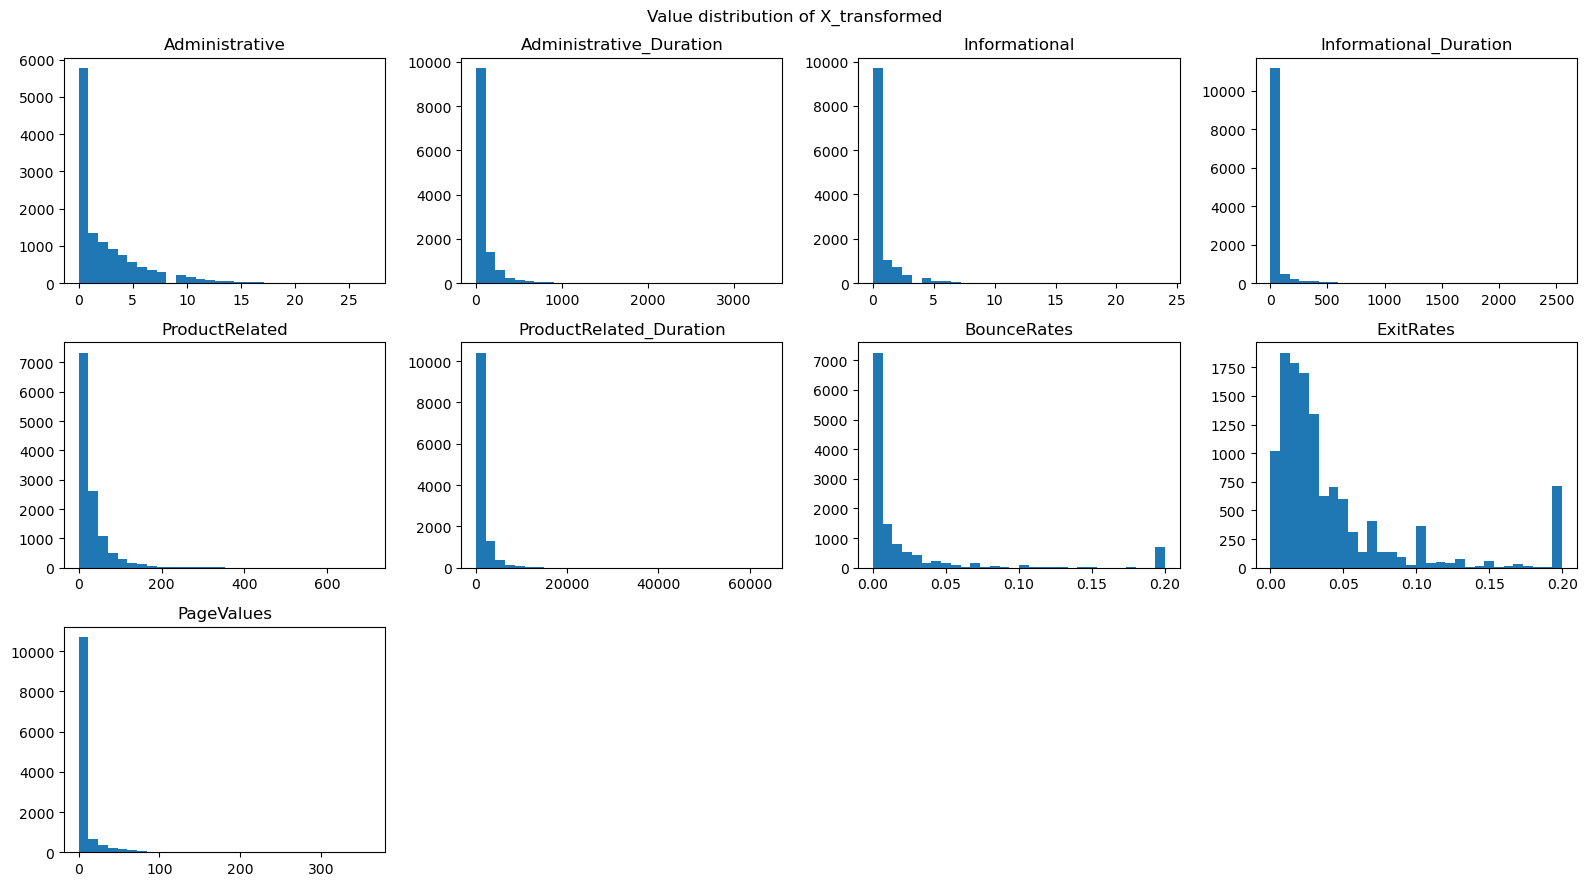

In [51]:
plothists(X_transformed, input_feature_continuous, 'X_transformed')

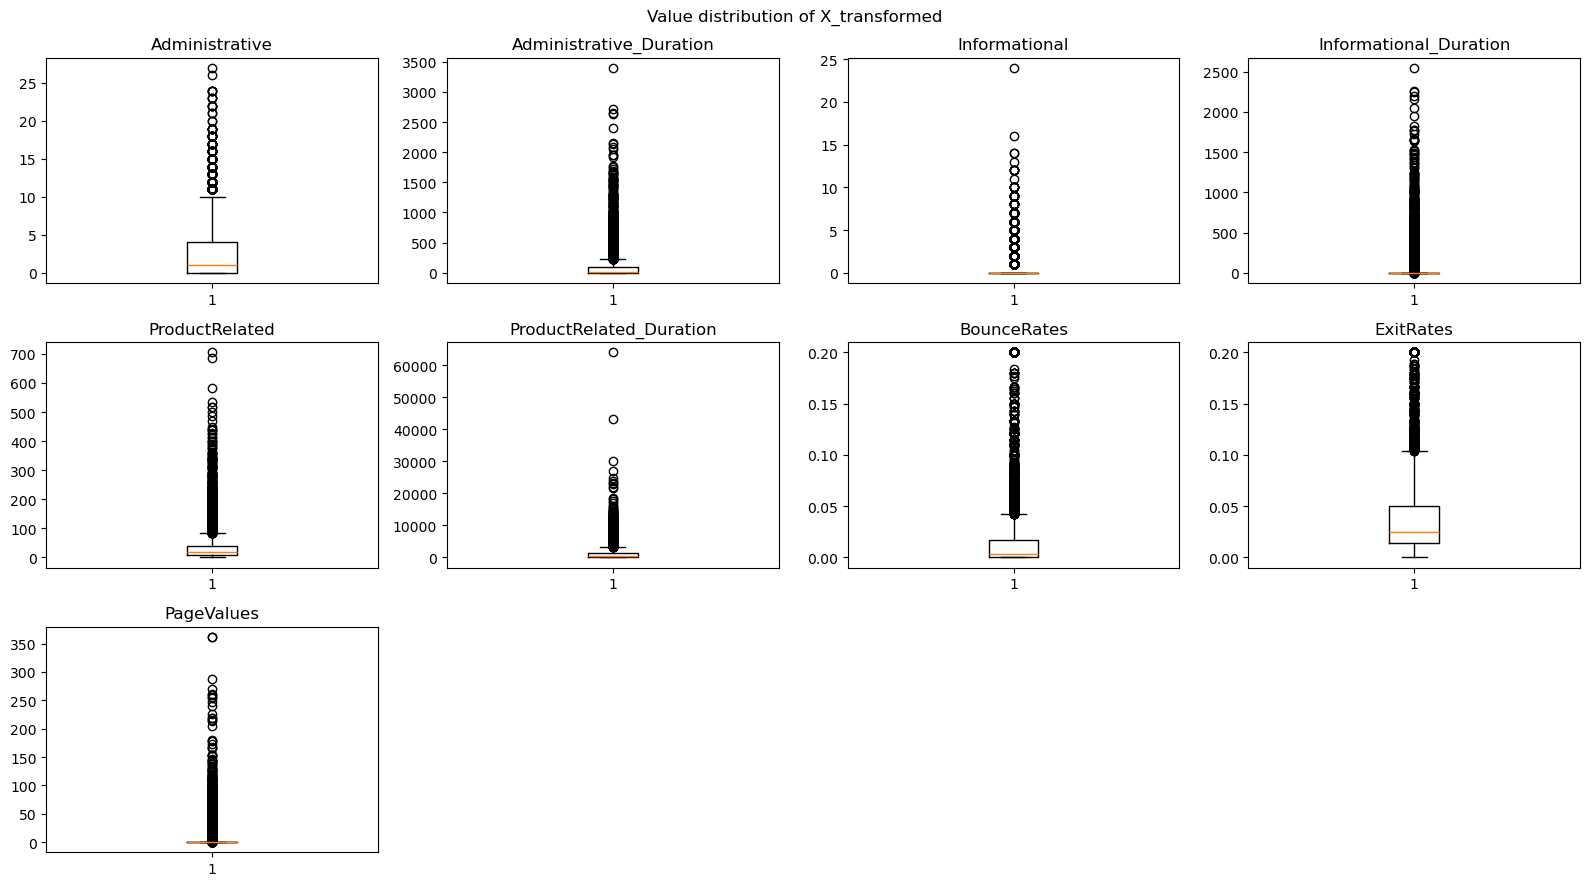

In [52]:
plotboxes(X_transformed, input_feature_continuous, 'X_transformed')

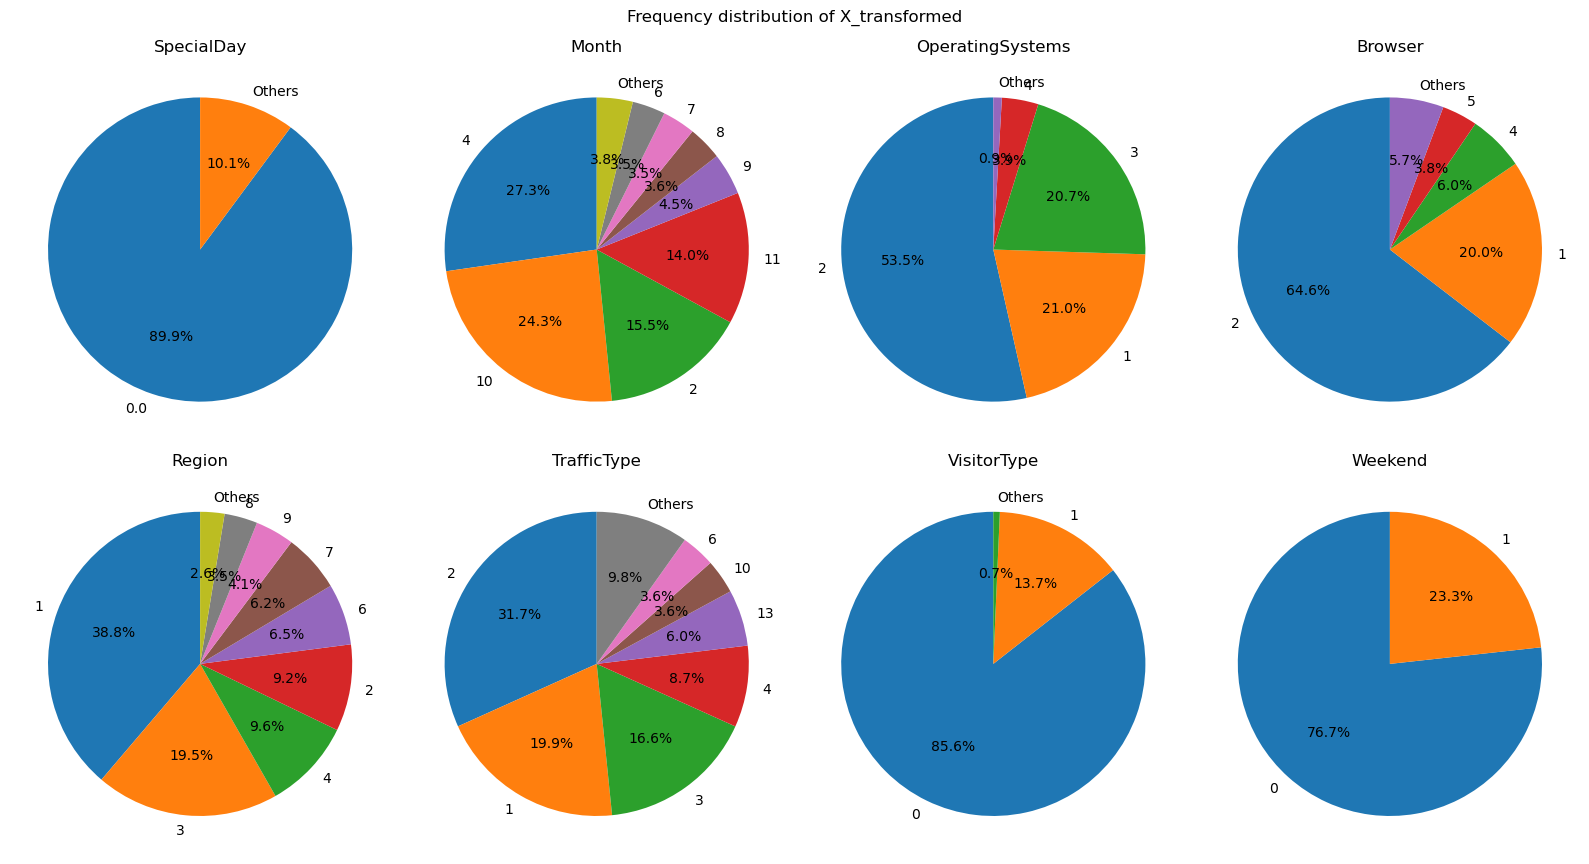

In [53]:
plotfreqpies(X_transformed, input_feature_enums, 'X_transformed', max_percentage=0.03)

We will compare these frequencies and distributions with the processed data ones.

# Data Processing

In this section, we are a going to tranform our data in a inreversable way.

It should be impossible to a algorithm that only consume this data to reverse this operation

For exemple, deleting a row is unreversable since we cannot recover that row with only the given data

## Cleaning missing data

In [54]:
X_transformed.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
dtype: int64

As we can see, no data is missing so there is no need to delete or process the missing data

 ## Resampling

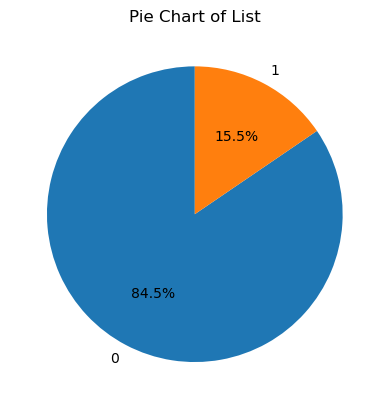

In [55]:
plotfreqpie(Y_transformed, 'Y_transformed')

In [56]:
Y_transformed.value_counts()

0    10422
1     1908
Name: Revenue, dtype: int64

As we can see, our data is not balanced. We have 10422 sessions that did not buy anything and 1908 sessions that did buy something.  

During future traing, this can lead to some issue in order to find the maximum accuracy since the model would have trained more on a class than another.  

We need to balance our data in order to have the same amount of both session.

In my case, I will use Undersampling, wich is a technique that consists of removing the majority class.  

In [57]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, Y_resampled = rus.fit_resample(X_transformed, Y_transformed)
X_resampled = X_resampled.reset_index(drop=True)
Y_resampled = Y_resampled.reset_index(drop=True)

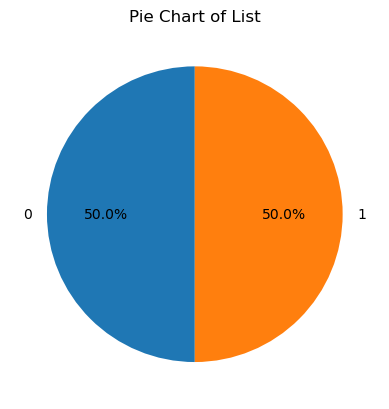

In [58]:
plotfreqpie(Y_resampled, 'Y_resampled')

In [59]:
Y_resampled.value_counts()

0    1908
1    1908
Name: Revenue, dtype: int64

We now have 1908 * 2 = 3816 entries in our data and the output feature is now balanced

## Visualizing

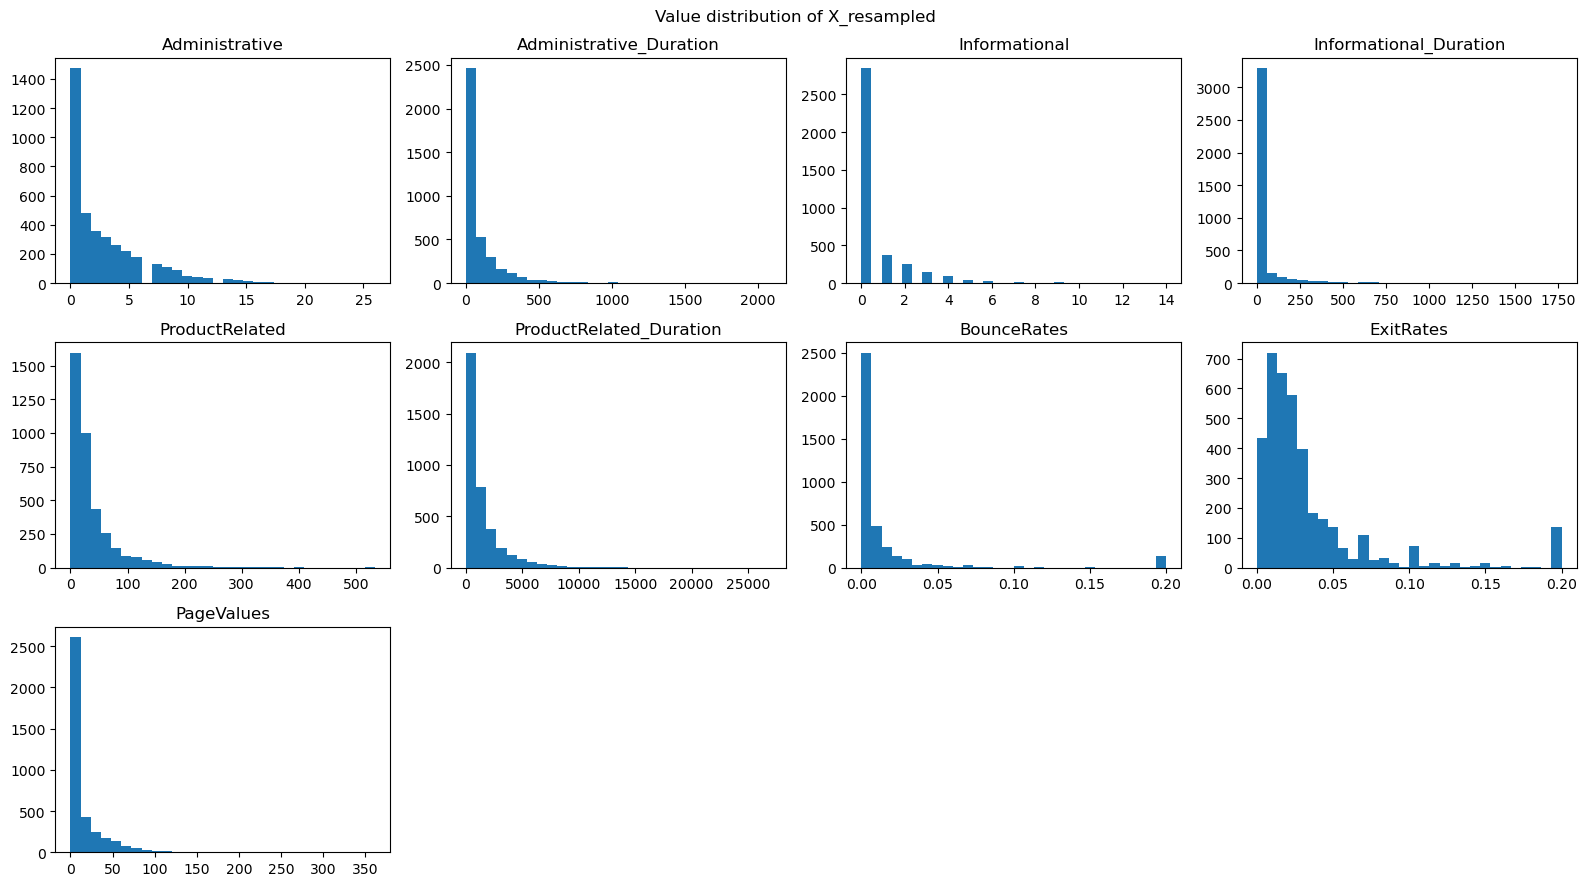

In [60]:
plothists(X_resampled, input_feature_continuous, 'X_resampled')

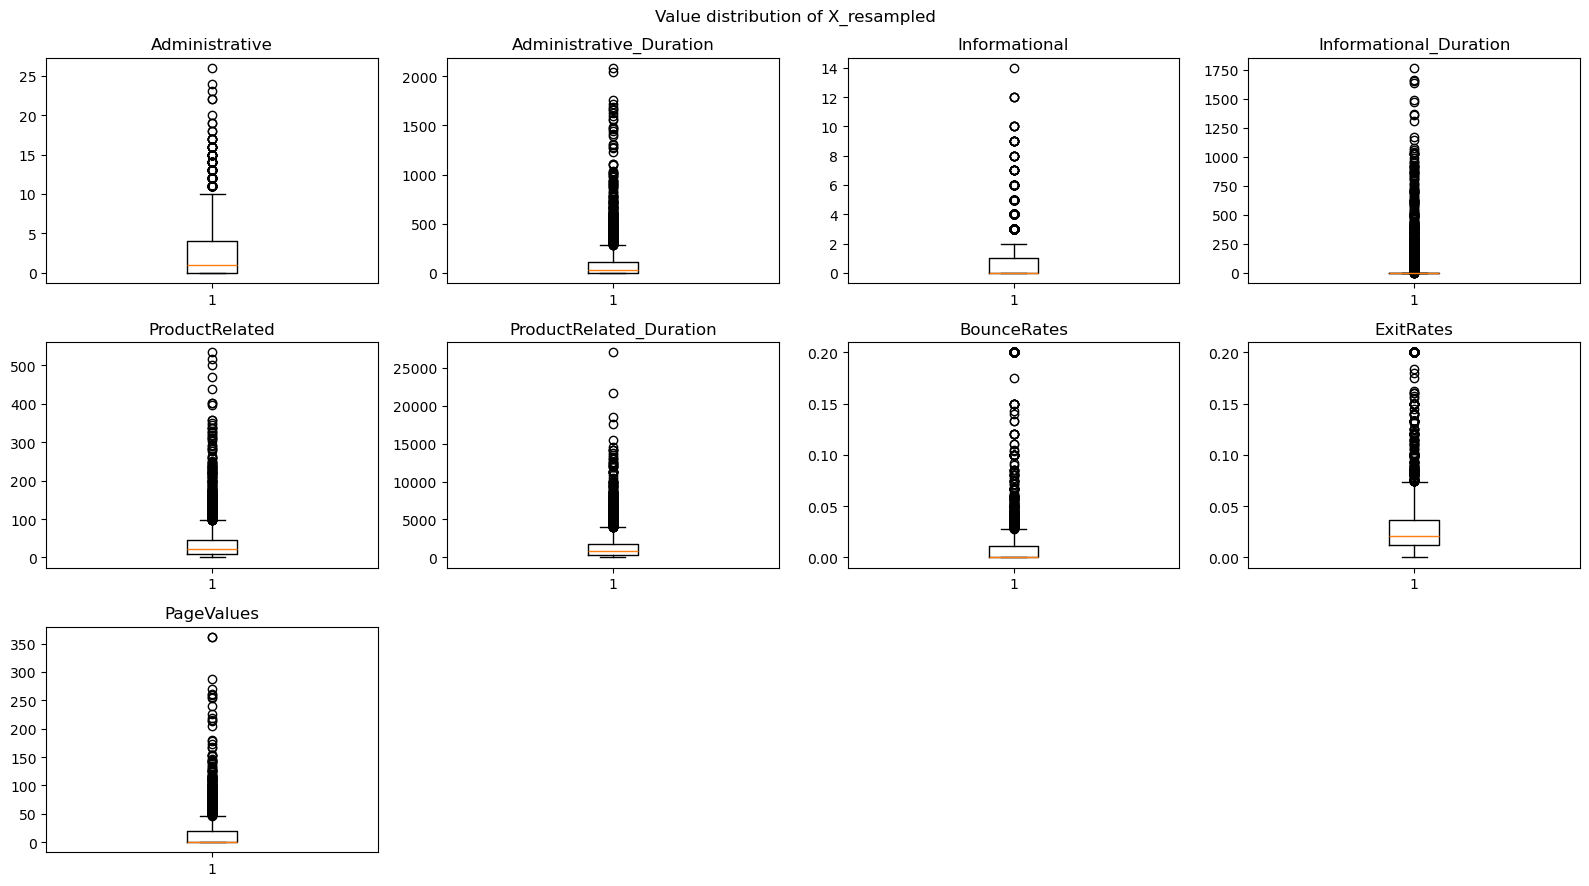

In [61]:
plotboxes(X_resampled, input_feature_continuous, 'X_resampled')

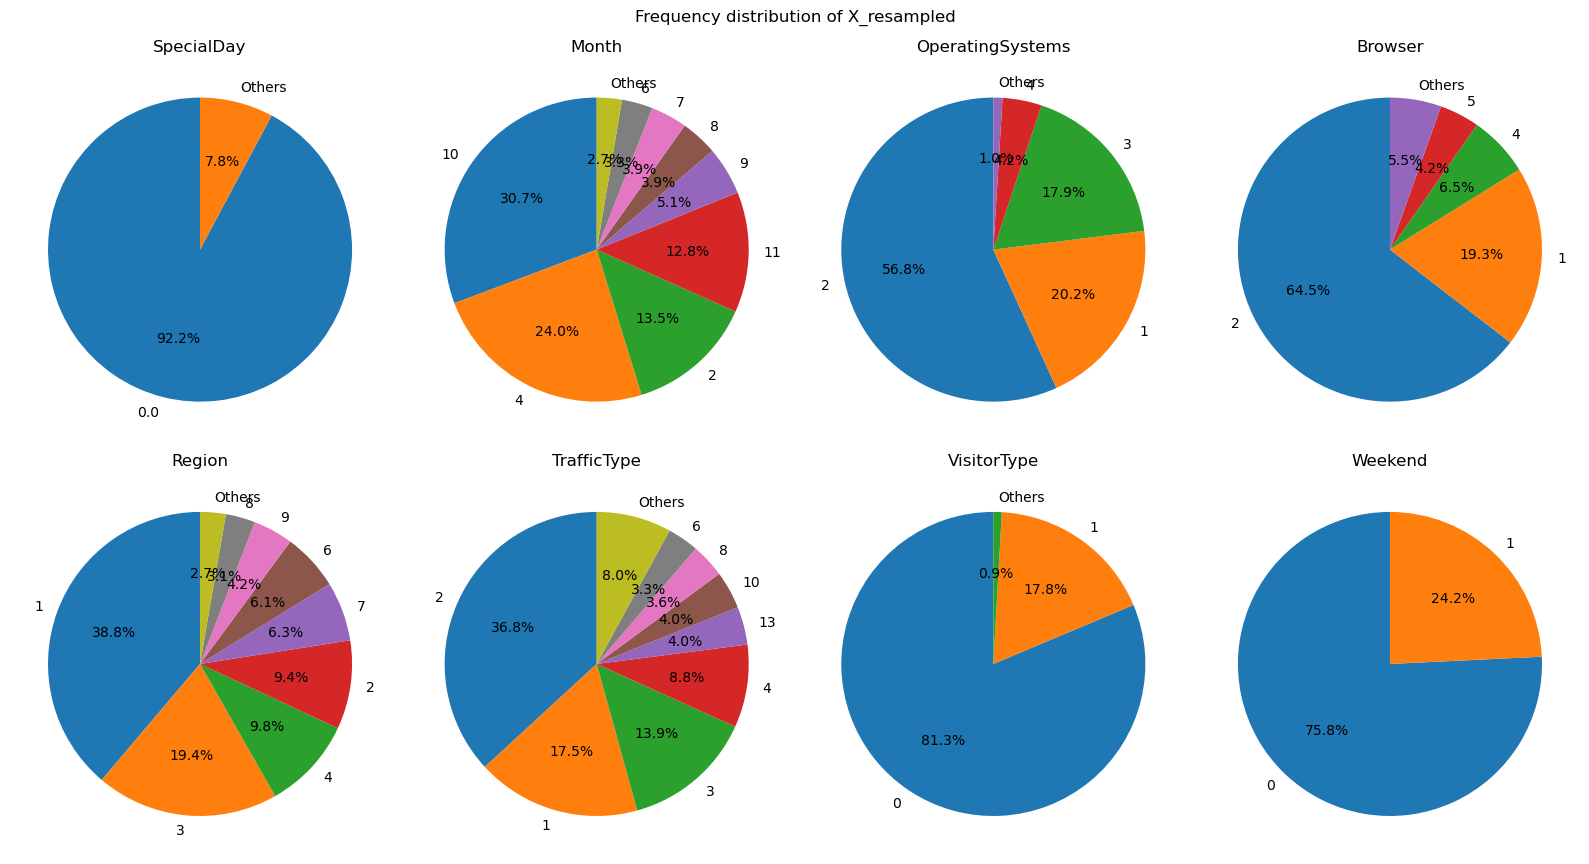

In [32]:
plotfreqpies(X_resampled, input_feature_enums, 'X_resampled')

## Correlation

/tmp/ipykernel_62077/1622604904.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = db_raw.corr('pearson')


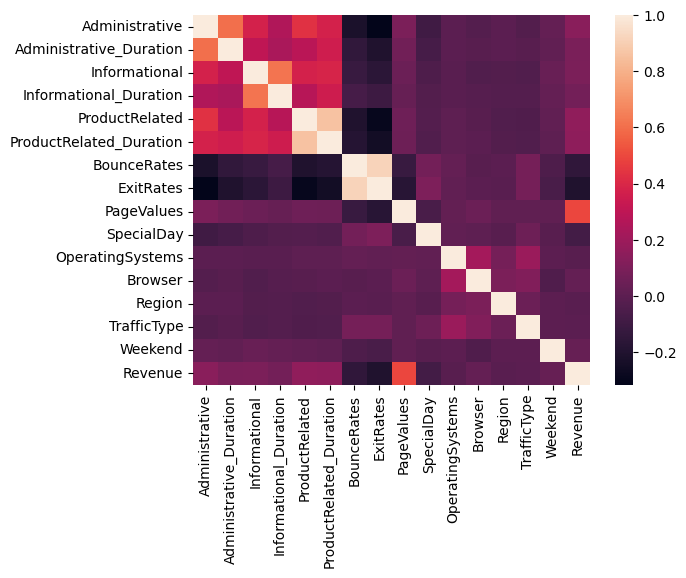

In [62]:
import seaborn

corr = db_raw.corr('pearson')
map = seaborn.heatmap(corr)

/tmp/ipykernel_62077/837481267.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = db_raw.corr('kendall')


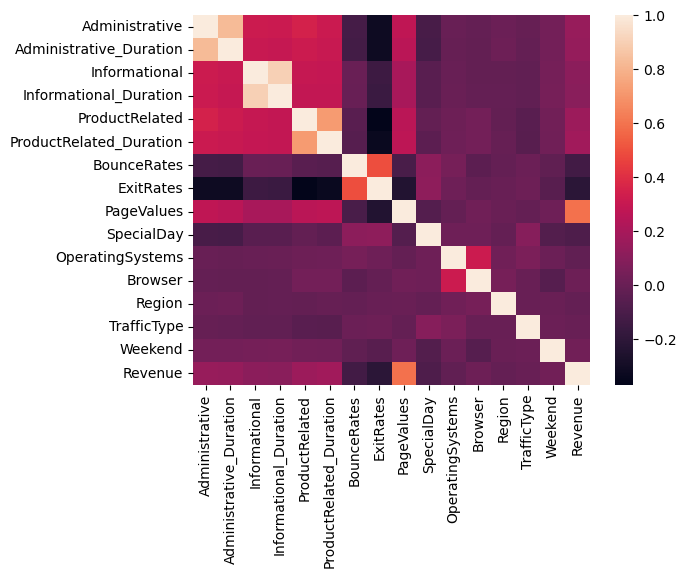

In [63]:
corr = db_raw.corr('kendall')
map = seaborn.heatmap(corr)

/tmp/ipykernel_62077/2883567133.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = db_raw.corr('spearman')


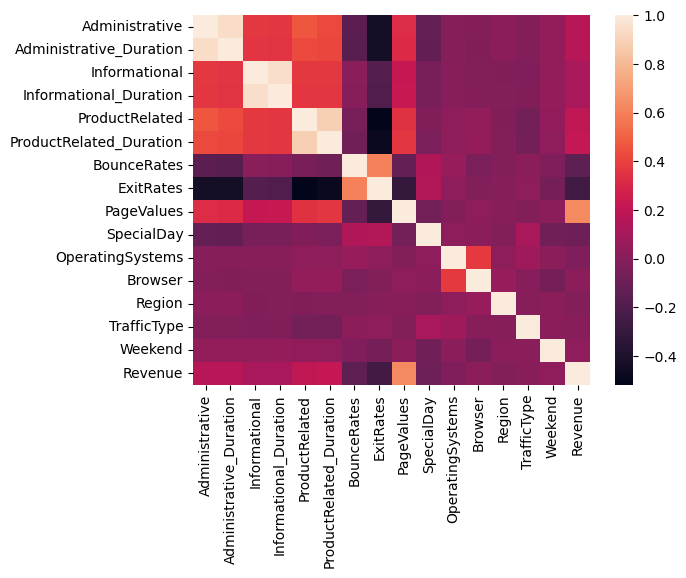

In [64]:
corr = db_raw.corr('spearman')
map = seaborn.heatmap(corr)

As we can see, some data are heavely correlated (Administrative, Administrative_Duration...). This mean that there is a statistical relationship between them


We can delete the columns that are not corelated to Revenue, decreased our number of features :

In [34]:
X_corr = X_resampled.drop(['ExitRates', 'SpecialDay', 'Region', 'TrafficType', 'OperatingSystems'], axis=1)

I will add these column :

  - Administrative & Administrative_Duration -> duration ratio
  - Informational & Informational_Duration -> duration ratio
  - ProductRelated & ProductRelated_Duration -> duration ratio

In [35]:
def ratio_duration(dataset, column):
  count = dataset[column].replace(0, 1)
  dataset[f'{column}_Avg'] = dataset[f'{column}_Duration'] / count

ratio_duration(X_corr, 'Administrative')
ratio_duration(X_corr, 'Informational')
ratio_duration(X_corr, 'ProductRelated')

## Normalizing

Our data is not on the same scale. To fix that, we will normalize it using StandardScaler

In [36]:
additional = ['Administrative_Avg', 'Informational_Avg', 'ProductRelated_Avg']
X_normalized, X_scaler = standard_scale(X_corr, input_feature_continuous + additional)

In [37]:
X_normalized

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,PageValues,Month,Browser,VisitorType,Weekend,Administrative_Avg,Informational_Avg,ProductRelated_Avg
0,0.353502,0.447637,2.453573,0.818059,-0.684793,-0.620492,-0.386639,-0.511955,11,2,0,0,0.446639,0.340360,0.391264
1,-0.790657,-0.523516,-0.444689,-0.292465,-0.644355,-0.567951,-0.386639,-0.511955,2,1,0,1,-0.484863,-0.271543,0.376814
2,-0.790657,-0.523516,-0.444689,-0.292465,-0.624135,0.050305,-0.021131,-0.511955,11,1,0,0,-0.484863,-0.271543,4.845525
3,0.067462,-0.430852,-0.444689,-0.292465,0.487930,0.024381,-0.142967,-0.511955,11,2,0,0,-0.366356,-0.271543,-0.398960
4,0.639541,0.083160,-0.444689,-0.292465,2.024602,1.375522,-0.386639,0.106266,10,2,0,0,-0.019338,-0.271543,-0.234994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3811,0.925581,0.203986,-0.444689,-0.292465,0.123981,0.615069,-0.334424,2.918828,10,2,0,1,-0.019664,-0.271543,0.573928
3812,1.211621,0.237281,-0.444689,-0.292465,-0.159090,-0.231271,-0.386639,0.763897,11,10,1,0,-0.067872,-0.271543,-0.164283
3813,-0.504617,-0.523516,1.004442,1.149737,2.145918,1.605208,-0.351829,-0.511955,10,2,0,0,-0.484863,1.317775,-0.184238
3814,1.211621,0.296053,0.279877,-0.231022,3.702809,5.036832,-0.101386,-0.456477,10,5,0,1,-0.035659,-0.136122,0.338328


## Encoding

Our data contains features that represents a class. Encoding these feature can help some model, especially deep neural network

In [38]:
X_enc, X_encoder = onehot_encode(X_normalized, input_feature_enums)

In [39]:
X_enc

,Weekend_1,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_10,Browser_11,...,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,PageValues,Administrative_Avg,Informational_Avg,ProductRelated_Avg
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.447637,2.453573,0.818059,-0.684793,-0.620492,-0.386639,-0.511955,0.446639,0.340360,0.391264
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.523516,-0.444689,-0.292465,-0.644355,-0.567951,-0.386639,-0.511955,-0.484863,-0.271543,0.376814
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.523516,-0.444689,-0.292465,-0.624135,0.050305,-0.021131,-0.511955,-0.484863,-0.271543,4.845525
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.430852,-0.444689,-0.292465,0.487930,0.024381,-0.142967,-0.511955,-0.366356,-0.271543,-0.398960
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.083160,-0.444689,-0.292465,2.024602,1.375522,-0.386639,0.106266,-0.019338,-0.271543,-0.234994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3811,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.203986,-0.444689,-0.292465,0.123981,0.615069,-0.334424,2.918828,-0.019664,-0.271543,0.573928
3812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.237281,-0.444689,-0.292465,-0.159090,-0.231271,-0.386639,0.763897,-0.067872,-0.271543,-0.164283
3813,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.523516,1.004442,1.149737,2.145918,1.605208,-0.351829,-0.511955,-0.484863,1.317775,-0.184238
3814,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.296053,0.279877,-0.231022,3.702809,5.036832,-0.101386,-0.456477,-0.035659,-0.136122,0.338328


## Finalization

We can now use this dataset

In [40]:
data = ReadyDataset('Original', X_enc, Y_resampled, 0.6, 0.2)

In [41]:
data.X_train

,Weekend_1,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_10,Browser_11,...,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,PageValues,Administrative_Avg,Informational_Avg,ProductRelated_Avg
660,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.490811,0.279877,-0.292465,0.144201,0.069472,0.725778,1.387467,-0.359385,-0.271543,-0.103223
630,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.523516,-0.444689,-0.292465,-0.624135,-0.720781,-0.386639,-0.511955,-0.484863,-0.271543,-0.980535
2272,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.319111,-0.444689,-0.292465,-0.523038,-0.539705,-0.386639,1.030236,-0.092743,-0.271543,-0.207856
1249,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.229466,-0.444689,-0.292465,-0.159090,-0.148198,-0.386639,-0.511955,0.355842,-0.271543,-0.017827
1584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.523516,-0.444689,-0.292465,-0.684793,-0.706456,-0.386639,-0.511955,-0.484863,-0.271543,-0.745397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.242799,1.004442,0.386821,-0.462380,-0.339525,-0.130784,0.027771,0.053648,0.477035,0.331241
1294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.365442,-0.444689,-0.292465,-0.725232,-0.723303,1.532280,-0.511955,-0.282704,-0.271543,-0.894788
860,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.523516,-0.444689,-0.292465,-0.624135,-0.562319,-0.386639,-0.511955,-0.484863,-0.271543,0.216753
3507,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.523516,-0.444689,-0.292465,-0.502819,-0.455514,-0.386639,0.403051,-0.484863,-0.271543,0.070542


# Modeling

## Chosing model

In order to chose the best model, we will perform a grid search for different classifier.

In [42]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

models = {
    DummyClassifier(random_state=42): {},
    MLPClassifier(random_state=42): {
        'hidden_layer_sizes': [(15, 10, 10, 5), (14, 9, 4), (15, 10, 5)],
        'activation': ['relu'],
        'alpha': [0.001],
        'max_iter': [2000]
    },
    RandomForestClassifier(random_state=42): {
        'n_estimators': [50, 100],
        'max_depth': [11, 13, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    DecisionTreeClassifier(random_state=42): {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 7, 9, 11],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    AdaBoostClassifier(random_state=42): {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1],
    },
    SVC(random_state=42): {
        'C': [0.1, 1],
        'kernel': ['linear', 'poly'],
        'degree': [2],
        'gamma': ['scale', 'auto'],
    }
}

Now let's iterate over the models, datasets and normalize and store that data

WARNING : This function is costy

In [43]:
results = []

for model, params in models.items():
  helper = ModelHelper(data, model, params)
  helper.fit()
  result = (type(model).__name__, helper.best_model(), helper.best_params(), helper.accuracy)
  results.append(result)
  print(f'{result[0]}')
  print(f'    best_params:{result[2]}')
  print(f'    accuracy:{result[3]}%')

DummyClassifier
    best_params:{}
    accuracy:50.26%
MLPClassifier
    best_params:{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (15, 10, 5), 'max_iter': 2000}
    accuracy:81.02%
RandomForestClassifier
    best_params:{'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
    accuracy:84.95%
DecisionTreeClassifier
    best_params:{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
    accuracy:85.08%
AdaBoostClassifier
    best_params:{'learning_rate': 0.1, 'n_estimators': 100}
    accuracy:84.82%
SVC
    best_params:{'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
    accuracy:81.81%


We now have records for various classifier, so we can analyze them

## Visualizing

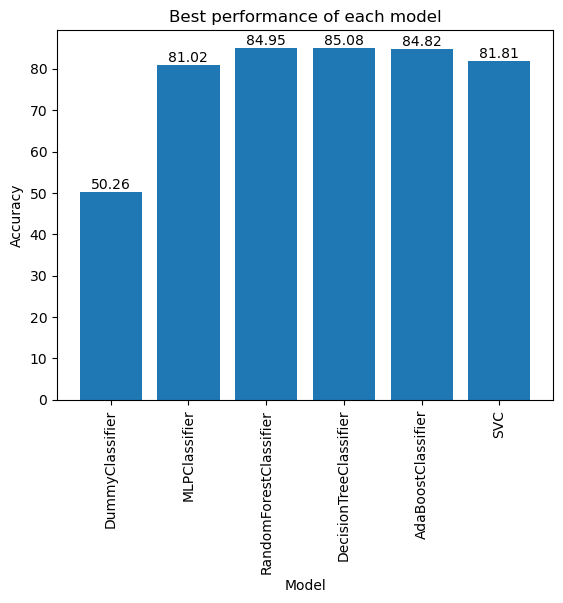

In [44]:
perf = {result[0]:result[3] for result in results}
plotbar(perf, 'Model', 'Accuracy', 'Best performance of each model')

In [45]:
for result in results:
  print(f'{result[0]} : {result[2]}')

DummyClassifier : {}
MLPClassifier : {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (15, 10, 5), 'max_iter': 2000}
RandomForestClassifier : {'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
DecisionTreeClassifier : {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
AdaBoostClassifier : {'learning_rate': 0.1, 'n_estimators': 100}
SVC : {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


We can obtain the best model using

In [46]:
ready_model = sorted(results, key=lambda x:x[3])[-1][1]

In [47]:
ready_model

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2,
                       random_state=42)

# Deploying

This server is deployed on http://127.0.0.1:5000 and contains a single endpoint at /predict

When doing a POST request on this endpoint with the input in the json, you will get a boolean coresponding to the y label

You can try this command to do a request : 

In [ ]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def endpoint():
    jsonDict = request.get_json()
    json = pd.DataFrame(jsonDict, index=[0])
    json['VisitorType'] = json['VisitorType'].map(visitor_types)
    json['Month'] = json['Month'].map(months)
    json['Weekend'] = json['Weekend'].astype(int)
    ratio_duration(json, 'Administrative')
    ratio_duration(json, 'Informational')
    ratio_duration(json, 'ProductRelated')
    
    columns = list(set(input_feature_enums) & set(X_normalized.columns))
    encoded = X_encoder.transform(json[columns])
    encoded = pd.DataFrame(encoded, columns=X_encoder.get_feature_names_out(columns))

    columns = list(set(input_feature_continuous+additional) & set(X_normalized.columns))
    normalized = pd.DataFrame(X_scaler.transform(json[columns]), columns=columns, index=[0])
    
    x = pd.concat([encoded, normalized], axis=1)
    x = x[list(data.X_train.columns)]
    y = ready_model.predict(x)
    
    response_data = {'result': bool(y[0])}
    print()
    print(f'Input: {jsonDict}')
    print(f'Output: {bool(y[0])}')
    
    return jsonify(response_data)

app_thread = app.run(debug=False, use_reloader=False, threaded=True)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [11/Dec/2023 10:21:26] "POST /predict HTTP/1.1" 200 -



Input: {'Administrative': 3, 'Administrative_Duration': 87.83333333, 'Informational': 0, 'Informational_Duration': 0.0, 'ProductRelated': 27, 'ProductRelated_Duration': 798.3333333, 'BounceRates': 0.0, 'ExitRates': 0.012643678, 'PageValues': 22.9160357, 'SpecialDay': 0.8, 'Month': 'Feb', 'OperatingSystems': 2, 'Browser': 2, 'Region': 3, 'TrafficType': 1, 'VisitorType': 'Returning_Visitor', 'Weekend': False}
Output: True


127.0.0.1 - - [11/Dec/2023 10:21:50] "POST /predict HTTP/1.1" 200 -



Input: {'Administrative': 3, 'Administrative_Duration': 87.83333333, 'Informational': 0, 'Informational_Duration': 0.0, 'ProductRelated': 0, 'ProductRelated_Duration': 0.3333333, 'BounceRates': 0.0, 'ExitRates': 0.012643678, 'PageValues': 0.0160357, 'SpecialDay': 0.8, 'Month': 'Feb', 'OperatingSystems': 2, 'Browser': 2, 'Region': 3, 'TrafficType': 1, 'VisitorType': 'Returning_Visitor', 'Weekend': False}
Output: False


127.0.0.1 - - [11/Dec/2023 10:21:53] "POST /predict HTTP/1.1" 200 -



Input: {'Administrative': 3, 'Administrative_Duration': 87.83333333, 'Informational': 0, 'Informational_Duration': 0.0, 'ProductRelated': 0, 'ProductRelated_Duration': 0.3333333, 'BounceRates': 0.0, 'ExitRates': 0.012643678, 'PageValues': 0.0160357, 'SpecialDay': 0.8, 'Month': 'Feb', 'OperatingSystems': 2, 'Browser': 2, 'Region': 3, 'TrafficType': 1, 'VisitorType': 'Returning_Visitor', 'Weekend': False}
Output: False
